In [1]:
import pandas as pd
import numpy as np
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import pickle
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR 
from sklearn.ensemble import AdaBoostRegressor as ADA
from sklearn.ensemble import BaggingRegressor as BAG
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import RANSACRegressor as RAN
from sklearn.linear_model import PassiveAggressiveRegressor as PAR
from sklearn.linear_model import SGDRegressor as SGD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_regression
from sklearn import preprocessing

In [5]:
class ensemble_search:
    def __init__(self, X_train, y_train, X_test, y_test, size_pop=20, epochs=5, train_test_size=0.2, random_state=1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.size_pop = size_pop
        self.epochs = epochs
        self.fitness_array_ = np.array([])
        self.best_of_all_ = None

    def gen_population(self):
        
        population = [[]]*self.size_pop
        
        for i in range(self.size_pop):
            
            qt_regressor = np.random.randint(2,9)
            lista_LR = ['LR',LR(), {}]
            
            lista_RFR = ['RFR',RFR(), {'n_estimators':np.random.randint(1,100),'max_depth':np.random.randint(1,20),
                                       'min_samples_split':np.random.randint(2,5),
                                       'min_samples_leaf':np.random.randint(2,10),
                                       'min_weight_fraction_leaf':np.random.rand(1)[0]/2}]
            
            lista_SVR = ['SVR',SVR(),{'kernel':random.choice(['linear','rbf','poly','sigmoid']),
                                      'epsilon':np.random.rand(1)[0]/4,
                                      'C':random.choice([1,10,100,1000]),'gamma':'auto'}]
            
            lista_ADA = ['ADA',ADA(), {'n_estimators':np.random.randint(1,50)}]
            
            lista_BAG = ['BAG',BAG(), {'n_estimators':np.random.randint(1,50),'max_samples':np.random.randint(1,20)}]
            
            lista_GBR = ['GBR',GBR(), {'n_estimators':np.random.randint(1,100),'max_depth':np.random.randint(1,20),
                                        'min_samples_split':np.random.randint(2,5),
                                        'min_samples_leaf':np.random.randint(2,10),
                                        'min_weight_fraction_leaf':np.random.rand(1)[0]/2}]
            
            lista_RAN = ['RAN',RAN(), {}]
            
            lista_PAR = ['PAR',PAR(), {'C': np.random.randint(1,10), 'early_stopping':True,
                                       'n_iter_no_change':np.random.randint(1,10)}]
            
            lista_SGD = ['SGD',SGD(), {}]
            
            lista_regressors = [lista_LR,lista_RFR,lista_SVR,lista_ADA,lista_BAG,lista_GBR,lista_RAN,lista_PAR,lista_SGD]
            
            random.shuffle(lista_regressors)
            
            lista_regressors = lista_regressors[0:qt_regressor]
            
            for j in range(len(lista_regressors)):
                lista_regressors[j][1] = lista_regressors[j][1].set_params(**lista_regressors[j][2])

            population[i] = [qt_regressor, lista_regressors, 'voting_regressor', np.inf]
            
        return population

    def set_fitness(self, population):
        for i in range(len(population)):
            
            lista_tuplas_VR = []
            nomes = []
            for indv in population[i][1]:
                
                while indv[0] in nomes: #adionar X se o nome já estiver dentro
                    indv[0] = indv[0]+'X'
                nomes.append(indv[0])
                
                lista_tuplas_VR.append((indv[0],indv[1])) #aqui vai pegando cada regressor do indivíduo (lista de regressores),
                                                          #que é formado pelo nome do regressor e o objeto.
                
            Voting_regressor = VotingRegressor(lista_tuplas_VR)
            Voting_regressor.fit(self.X_train, self.y_train)
            
            mae_vr = mae(Voting_regressor.predict(self.X_test), self.y_test)
            population[i][-1] = mae_vr
            population[i][-2] = Voting_regressor
            
        return population
    
    def next_population(self, population):
        
        for i in range(1, int(len(population)/2)):
            qt_regs_pai1 = population[i][0]
            qt_regs_pai2 = population[2*i][0]
            
            #aqui mistura os regressores
            if qt_regs_pai1<=qt_regs_pai2:    
                population[i][1][:int(qt_regs_pai1/2)] = population[2*i][1][:int(qt_regs_pai1/2)]
            else:
                population[i][1][:int(qt_regs_pai2/2)] = population[2*i][1][:int(qt_regs_pai2/2)]
                
            #modificar nomes dos regressores se houver repetido
            nomes = []
            for reg in population[i][1]:
                while reg[0] in nomes: #adionar X se o nome já estiver dentro
                    reg[0] = reg[0]+'X'
                nomes.append(reg[0])
        
        return population
    
    def early_stop(self):
        array = self.fitness_array_
        to_break=False
        if len(array) > 4:
            array_diff1_1 = array[1:] - array[:-1]
            array_diff1_2 = array[2:] - array[:-2]
            array_diff2 = array_diff1_1[1:] - array_diff1_1[:-1]
            if array_diff2[-2:].mean() < 0:
                to_break = True
        
        return to_break

    def search_best(self):
        population = self.gen_population()
        population = self.set_fitness(population)
        population.sort(key = lambda x: x[-1])  
        self.fitness_array_ = np.append(self.fitness_array_, population[0][-1])
        self.best_of_all_ = population[0][-2]
        
        for i in tqdm(range(self.epochs)):
            population = self.next_population(population)
            population = self.set_fitness(population)
            population.sort(key = lambda x: x[-1])
            
            #pegar o melhor de todas as épocas
            
            if population[0][-1] < min(self.fitness_array_):
                self.best_of_all_ = population[0][-2]
            
            #adicionar ao array de fitness o atual
            self.fitness_array_ = np.append(self.fitness_array_, population[0][-1])

            if self.early_stop():
                break
            
        return self 


n_samples = 1000
n_outliers = 50
X, y, coef = make_regression(n_samples=n_samples, n_features=1,n_informative=1, noise=10,coef=True, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Ensearch = ensemble_search(X_train, y_train, X_test, y_test, size_pop=10, epochs=15).search_best()
print(mse(Ensearch.best_of_all_.predict(X_test), y_test))

 20%|██        | 3/15 [00:02<00:10,  1.18it/s]


79.74187364118433


In [3]:
df_all_features_pvgis = pd.read_csv('df_all_features_pvgis.csv')
df_all_features_pvgis.iloc[:,2:] = preprocessing.minmax_scale(df_all_features_pvgis.iloc[:,2:].values)
df_all_features_pvgis.head()

,Latitude,Longitude,DirectNormal,DifuseRadiation,FotoActive,GlobalHorizonta,PlanoInclinado,InsolacaoTotal,PreciptacaoTotal,TempMaxMedia,...,Altitude,Umidade,TempMinimaMedia,PressaoMedia,Em_SARAH,Hm_SARAH,SDm_SARAH,Em_NSRDB,Hm_NSRDB,SDm_NSRDM
0,-9.5005,-40.749,0.879908,0.275253,0.870408,0.852729,0.829609,1.0,0.0,0.965599,...,0.329187,0.0,1.0,0.635759,0.695652,0.677419,0.411111,0.806452,0.800,0.172336
1,-9.5005,-40.649,0.840185,0.308081,0.822449,0.806385,0.787709,1.0,0.0,0.965599,...,0.329187,0.0,1.0,0.635759,0.695652,0.677419,0.394444,0.741935,0.725,0.142857
2,-9.5005,-40.549,0.787529,0.356061,0.774490,0.761071,0.729050,1.0,0.0,0.965599,...,0.329187,0.0,1.0,0.635759,0.608696,0.612903,0.455556,0.612903,0.625,0.136054
3,-9.4005,-40.749,0.886836,0.272727,0.869388,0.854789,0.837989,1.0,0.0,0.965599,...,0.329187,0.0,1.0,0.635759,0.739130,0.741935,0.370370,0.709677,0.700,0.077098
4,-9.4005,-40.649,0.872517,0.252525,0.844898,0.831102,0.818436,1.0,0.0,0.965599,...,0.329187,0.0,1.0,0.635759,0.652174,0.677419,0.414815,0.709677,0.725,0.160998


In [4]:
X = df_all_features_pvgis.drop(['Em_SARAH', 'Hm_SARAH', 'SDm_SARAH', 'Em_NSRDB', 'Hm_NSRDB', 'SDm_NSRDM'], axis=1)
Y_sarah = df_all_features_pvgis.Em_SARAH
Y_nsrdb = df_all_features_pvgis.Em_NSRDB

X_train_sarah, X_test_sarah, y_train_sarah, y_test_sarah = train_test_split(X, Y_sarah, test_size=0.20, random_state=1)
X_train_nsrdb, X_test_nsrdb, y_train_nsrdb, y_test_nsrdb = train_test_split(X, Y_nsrdb, test_size=0.20, random_state=1)

r1 = LR()
r2 = RFR()
r3 = SVR()
r4 = ADA()
r5 = BAG()
r6 = GBR()
r7 = RAN()
r8 = PAR()
r9 = SGD()

er_sarah = VotingRegressor([('lr', r1), ('rf', r2), ('svr', r3), ('ada', r4), ('bag', r5), ('gbr', r6),
                      ('ransac', r7), ('par', r8), ('sgd', r9)])

er_nsrdb = VotingRegressor([('lr', r1), ('rf', r2), ('svr', r3), ('ada', r4), ('bag', r5), ('gbr', r6),
                      ('ransac', r7), ('par', r8), ('sgd', r9)])

In [6]:
Ensearch_sarah = ensemble_search(X_train_sarah.drop(['Latitude', 'Longitude'], axis=1), y_train_sarah,
                                 X_test_sarah.drop(['Latitude', 'Longitude'], axis=1), y_test_sarah, size_pop=50, epochs=10).search_best()

Ensearch_nsrdb = ensemble_search(X_train_nsrdb.drop(['Latitude', 'Longitude'], axis=1), y_train_nsrdb,
                                 X_test_nsrdb.drop(['Latitude', 'Longitude'], axis=1), y_test_nsrdb, size_pop=50, epochs=10).search_best()


 40%|████      | 4/10 [00:24<00:36,  6.01s/it]

In [7]:
ensearch_best_sarah = Ensearch_sarah.best_of_all_
ensearch_best_nsrdb = Ensearch_nsrdb.best_of_all_

In [8]:
pickle.dump(ensearch_best_sarah, open('Best_ensemble_sarah.pkl', 'wb'))
pickle.dump(ensearch_best_nsrdb, open('Best_ensemble_nsrdb.pkl', 'wb'))

In [9]:
best_er_sarah = pickle.load(open('Best_ensemble_sarah.pkl', 'rb'))
best_er_nsrdb = pickle.load(open('Best_ensemble_nsrdb.pkl', 'rb'))

y_sarah_pred = best_er_sarah.predict(X_test_sarah.drop(['Latitude', 'Longitude'], axis=1))
y_nsrdb_pred = best_er_nsrdb.predict(X_test_nsrdb.drop(['Latitude', 'Longitude'], axis=1))

In [10]:
er_sarah.fit(X_train_sarah.drop(['Latitude', 'Longitude'], axis=1), y_train_sarah)
y_sarah_pred_all = er_sarah.predict(X_test_sarah.drop(['Latitude', 'Longitude'], axis=1))

y_sarah_pred_ensearch = best_er_sarah.predict(X_test_sarah.drop(['Latitude', 'Longitude'], axis=1))

print('All Defaul')
print('Sarah MAE: ', mae(y_sarah_pred_all, y_test_sarah))
print('Sarah MSE: ', mse(y_sarah_pred_all, y_test_sarah))
print('Ensearch Best')
print('Sarah MAE: ', mae(y_sarah_pred_ensearch, y_test_sarah))
print('Sarah MSE: ', mse(y_sarah_pred_ensearch, y_test_sarah))

C:\Users\fitec\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fitec\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


All Defaul
Sarah MAE:  0.06397133246542393
Sarah MSE:  0.007299722540625673
Ensearch Best
Sarah MAE:  0.06561203094317156
Sarah MSE:  0.00748320477868336


In [11]:
er_nsrdb.fit(X_train_nsrdb.drop(['Latitude', 'Longitude'], axis=1), y_train_nsrdb)
y_nsrdb_pred_all = er_nsrdb.predict(X_test_nsrdb.drop(['Latitude', 'Longitude'], axis=1))

y_nsrdb_pred_ensearch = best_er_nsrdb.predict(X_test_nsrdb.drop(['Latitude', 'Longitude'], axis=1))

print('Ensemble All Defaul')
print('Em - NSRDB MAE: ', mae(y_nsrdb_pred_all, y_test_nsrdb))
print('Em - NSRDB MSE: ', mse(y_nsrdb_pred_all, y_test_nsrdb))
print('Ensearch Best')
print('Em - NSRDB MAE: ', mae(y_nsrdb_pred_ensearch, y_test_nsrdb))
print('Em - NSRDB MSE: ', mse(y_nsrdb_pred_ensearch, y_test_nsrdb))

C:\Users\fitec\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\fitec\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Ensemble All Defaul
Em - NSRDB MAE:  0.046177515560308365
Em - NSRDB MSE:  0.003514384437845586
Ensearch Best
Em - NSRDB MAE:  0.04103370462938976
Em - NSRDB MSE:  0.0030208314771003435


C:\Users\fitec\AppData\Roaming\Python\Python37\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


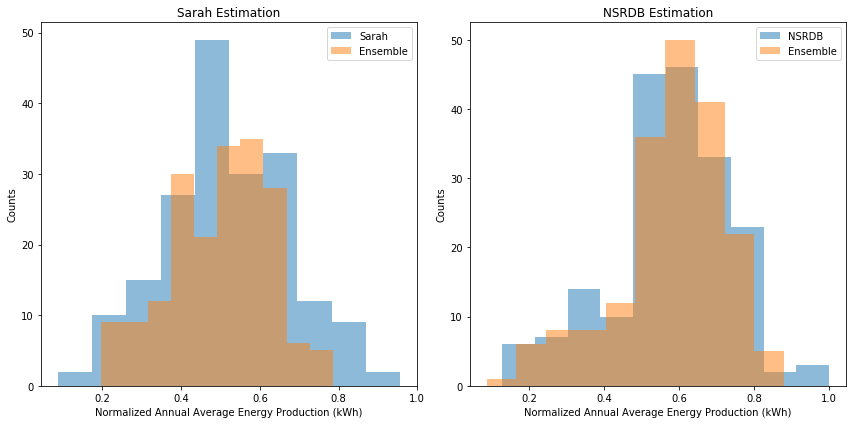

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.hist(y_test_sarah, label='Sarah', alpha=0.5, bins=10)
ax1.hist(y_sarah_pred, label='Ensemble', alpha = 0.5, bins=10)
ax1.set_title('Sarah Estimation')
ax1.set_ylabel('Counts')
ax1.set_xlabel('Normalized Annual Average Energy Production (kWh)')
ax1.legend()

ax2.hist(y_test_nsrdb, label='NSRDB', alpha = 0.5, bins=10)
ax2.hist(y_nsrdb_pred, label='Ensemble', alpha = 0.5, bins=10)
ax2.set_title('NSRDB Estimation')
ax2.set_ylabel('Counts')
ax2.set_xlabel('Normalized Annual Average Energy Production (kWh)')
ax2.legend()

In [14]:
to_plot_results_sarah_train = X_train_sarah.copy()
to_plot_results_sarah_train['Em_Sarah_train'] = y_train_sarah
to_plot_results_sarah_train['Em_Sarah_model_train'] = best_er_sarah.predict(X_train_sarah.drop(['Latitude', 'Longitude'], axis=1))

to_plot_results_sarah_test = X_test_sarah.copy()
to_plot_results_sarah_test['Em_Sarah_test'] = y_test_sarah
to_plot_results_sarah_test['Em_Sarah_model_test'] = y_sarah_pred

to_plot_results_sarah_train['Sarah_erro_train'] = abs(y_train_sarah - best_er_sarah.predict(X_train_sarah.drop(['Latitude', 'Longitude'], axis=1)))
to_plot_results_sarah_test['Sarah_erro_test'] = abs(y_test_sarah - y_sarah_pred)

to_plot_results_nsrdb_train = X_train_sarah.copy()
to_plot_results_nsrdb_train['Em_NSRDB_train'] = y_train_sarah
to_plot_results_nsrdb_train['Em_NSRDB_model_train'] = best_er_nsrdb.predict(X_train_nsrdb.drop(['Latitude', 'Longitude'], axis=1))

to_plot_results_nsrdb_test = X_test_nsrdb.copy()
to_plot_results_nsrdb_test['Em_NSRDB_test'] = y_test_nsrdb
to_plot_results_nsrdb_test['Em_NSRDB_model_test'] = y_nsrdb_pred

to_plot_results_nsrdb_train['NSRDB_erro_train'] = abs(y_train_sarah-best_er_nsrdb.predict(X_train_nsrdb.drop(['Latitude', 'Longitude'], axis=1)))
to_plot_results_nsrdb_test['NSRDB_erro_test'] = abs(y_test_nsrdb - y_nsrdb_pred)

# Visualizar Resultado

## Colocar mapa com erro entre modelo e valor real.

In [15]:
sf = shp.Reader("shapefile_PE/shapefile_PE.shp",encoding= "ISO-8859-1")

PE_map = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    if all(item < -34 for item in x):
        PE_map.append([x,y])

Text(0.5, 1.0, 'Normalized Estimated Energy Production on Pernambuco State - Ensemble')

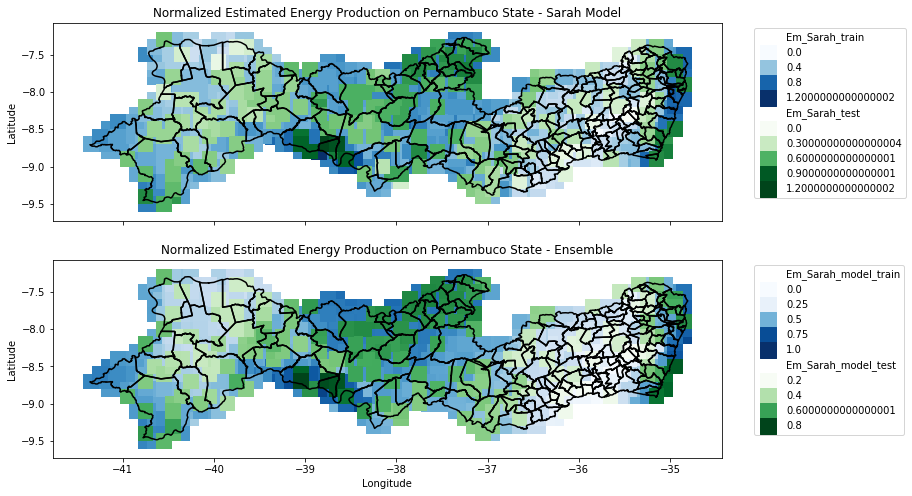

In [14]:
mpl.rcParams["scatter.marker"] = 's'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i in range(0,len(PE_map)):
        ax1.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_sarah_train, x='Longitude', y='Latitude', hue='Em_Sarah_train',
                palette = 'Blues', size='Em_Sarah_train', sizes=(230,250), linewidth=0, ax=ax1)

sns.scatterplot(data=to_plot_results_sarah_test, x='Longitude', y='Latitude', hue='Em_Sarah_test',
                palette = 'Greens', size='Em_Sarah_test', sizes=(230,250), linewidth=0, ax=ax1)

ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_xlabel('Longitude')
ax1.set_title('Normalized Estimated Energy Production on Pernambuco State - Sarah Model')

for i in range(0,len(PE_map)):
        ax2.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_sarah_train, x='Longitude', y='Latitude', hue='Em_Sarah_model_train',
                palette = 'Blues', size='Em_Sarah_model_train', sizes=(230,250), linewidth=0, ax=ax2)

sns.scatterplot(data=to_plot_results_sarah_test, x='Longitude', y='Latitude', hue='Em_Sarah_model_test',
                palette = 'Greens', size='Em_Sarah_model_test', sizes=(230,250), linewidth=0, ax=ax2)

ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Normalized Estimated Energy Production on Pernambuco State - Ensemble')

Text(0.5, 1.0, 'Normalized Estimated Energy Production on Pernambuco State - Ensemble')

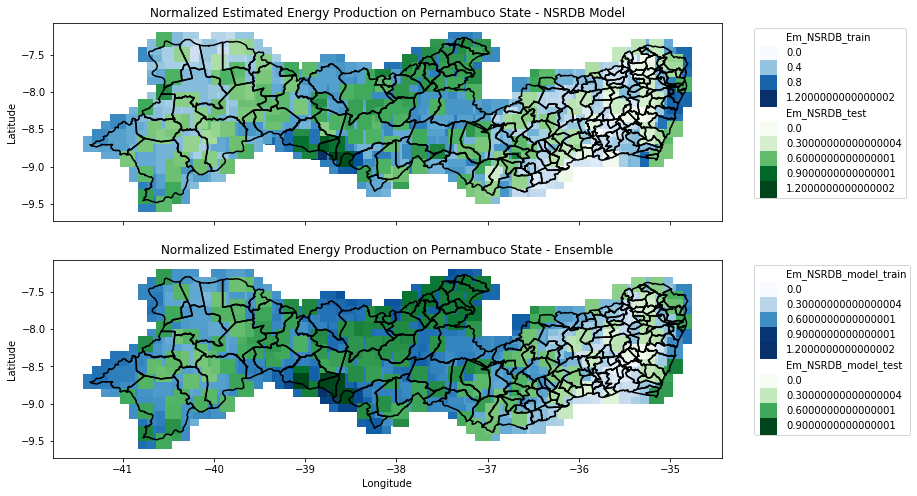

In [15]:
mpl.rcParams["scatter.marker"] = 's'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i in range(0,len(PE_map)):
        ax1.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_nsrdb_train, x='Longitude', y='Latitude', hue='Em_NSRDB_train',
                palette = 'Blues', size='Em_NSRDB_train', sizes=(230,250), linewidth=0, ax=ax1)

sns.scatterplot(data=to_plot_results_nsrdb_test, x='Longitude', y='Latitude', hue='Em_NSRDB_test',
                palette = 'Greens', size='Em_NSRDB_test', sizes=(230,250), linewidth=0, ax=ax1)

ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_xlabel('Longitude')
ax1.set_title('Normalized Estimated Energy Production on Pernambuco State - NSRDB Model')

for i in range(0,len(PE_map)):
        ax2.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_nsrdb_train, x='Longitude', y='Latitude', hue='Em_NSRDB_model_train',
                palette = 'Blues', size='Em_NSRDB_model_train', sizes=(230,250), linewidth=0, ax=ax2)

sns.scatterplot(data=to_plot_results_nsrdb_test, x='Longitude', y='Latitude', hue='Em_NSRDB_model_test',
                palette = 'Greens', size='Em_NSRDB_model_test', sizes=(230,250), linewidth=0, ax=ax2)

ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Normalized Estimated Energy Production on Pernambuco State - Ensemble')

Text(0.5, 1.0, 'Normalized Estimated Energy Production on Pernambuco State - Ensemble')

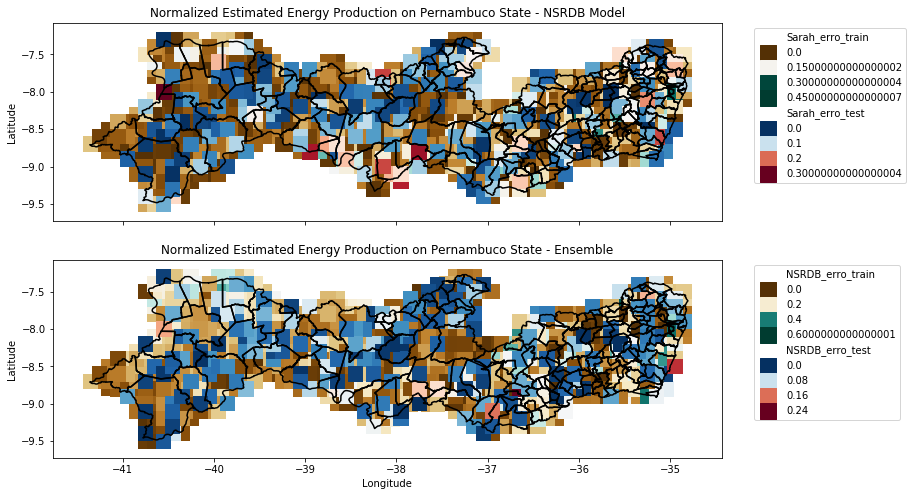

In [16]:
mpl.rcParams["scatter.marker"] = 's'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for i in range(0,len(PE_map)):
        ax1.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_sarah_train, x='Longitude', y='Latitude', hue='Sarah_erro_train',
                palette = 'BrBG', size='Sarah_erro_train', sizes=(230,250), linewidth=0, ax=ax1)

sns.scatterplot(data=to_plot_results_sarah_test, x='Longitude', y='Latitude', hue='Sarah_erro_test',
                palette = 'Purples', size='Sarah_erro_test', sizes=(230,250), linewidth=0, ax=ax1)

ax1.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.set_xlabel('Longitude')
ax1.set_title('Normalized Estimated Energy Production on Pernambuco State - Sarah Model')

for i in range(0,len(PE_map)):
        ax2.plot(PE_map[i][0],PE_map[i][1],'k')
                        
sns.scatterplot(data=to_plot_results_nsrdb_train, x='Longitude', y='Latitude', hue='NSRDB_erro_train',
                palette = 'BrBG', size='NSRDB_erro_train', sizes=(230,250), linewidth=0, ax=ax2)

sns.scatterplot(data=to_plot_results_nsrdb_test, x='Longitude', y='Latitude', hue='NSRDB_erro_test',
                palette = 'Purples', size='NSRDB_erro_test', sizes=(230,250), linewidth=0, ax=ax2)

ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Normalized Estimated Energy Production on Pernambuco State - Ensemble')